# Ensemble phase picking (continuous waveform, broadband)
- Yiyu Ni (niyiyu@uw.edu)
- Last updated: May 1, 2023
- PB.B204 station (EH channel)

## 0 import necessary packages

In [1]:
import gc
import obspy
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ELEP/elep/")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
pd.set_option('display.max_columns', None)

from matplotlib.patches import Rectangle
from ensemble_coherence import ensemble_semblance
from ensemble_statistics import ensemble_statistics
from trigger_func import picks_summary_simple
import seisbench.models as sbm
from tqdm import tqdm
from obspy.core.utcdatetime import UTCDateTime
from ensemble_learners import ensemble_regressor_cnn

## 1 Load data
We read mSEED from [PB.B204](https://ds.iris.edu/gmap/#network=PB&station=B204&planet=earth) station, Feb 6, 2023 (Julian day 037). The stream contains 5-hour 3-component waveform from EH channel (short period high-gain).

We read the number of data points in each trace, delta (reciprocal of sampling rate), and start time of the trace.

In [2]:
# from obspy.core.utcdatetime import UTCDateTime
# from obspy.clients.fdsn.client import Client

# client = Client("IRIS")

3 Trace(s) in Stream:
PB.B204..EH1 | 2022-02-06T00:00:00.008400Z - 2022-02-06T04:59:59.998400Z | 100.0 Hz, 1800000 samples
PB.B204..EH2 | 2022-02-06T00:00:00.008400Z - 2022-02-06T04:59:59.998400Z | 100.0 Hz, 1800000 samples
PB.B204..EHZ | 2022-02-06T00:00:00.008400Z - 2022-02-06T04:59:59.998400Z | 100.0 Hz, 1800000 samples


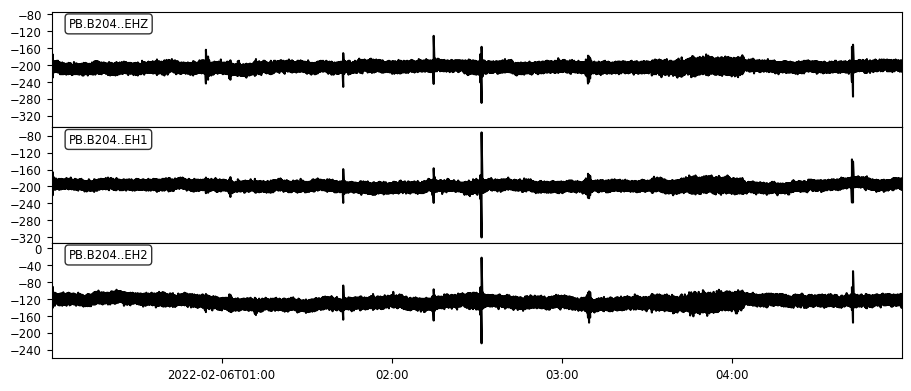

In [4]:
starttime = UTCDateTime("2022-02-06T00:00:00.000000")
endtime   = UTCDateTime("2022-02-06T04:59:59.999000")
# s = client.get_waveforms("PB", "B204", location = "*", channel = "EH?", 
#                          starttime = starttime, endtime = endtime)

s = obspy.read("./data/PB.B204..EH.ms")
print(s)
npts = s[0].stats.npts
delta = s[0].stats.delta
starttime = s[0].stats.starttime

fig =plt.figure(figsize = (10, 4))
s.plot(fig = fig);

## 2 Baseline using original pretrianed model

In [5]:
# cut continuous data into one-minute time window (6000 sample for EqTransformer)
# 3000 (50%, 30 seconds) sample overlap 
# mute 500 samples of prediction on both end of time window

twin = 6000     # length of time window
step = 3000     # step length
l_blnd, r_blnd = 500, 500
nseg = int(np.ceil((npts - twin) / step)) + 1

In [6]:
eqt = sbm.EQTransformer.from_pretrained('original')
eqt.to(torch.device("cuda"));
eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                 (only for window prediction models)', step)
eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                  each side of each window prediction', (l_blnd, r_blnd))
eqt.eval();

pcount = {"P":0, "S":0}
for i in eqt.classify(s)[0]:
    print(i)
    pcount[i.phase] += 1
print('--------------'*3)
print(f"{pcount['P']} P picks\n{pcount['S']} S picks")

PB.B204.	2022-02-06T02:31:29.308400Z	P
PB.B204.	2022-02-06T02:31:34.438400Z	S
------------------------------------------
1 P picks
1 S picks


## 3 ensemble phase picking
### 3.1 cut and predict on time windows
We cut the continuous data into small time windows with overlap. Then, we pre-process the stream and the windowed waveform: switch channel order, demean, normalization, and taper.

Note that `original` pretrain model use std normalization, while others use maximum normalization. Thus, we create two different windowed data: `windows_std` and `windows_max`.

In [10]:
s2 = eqt.annotate_stream_pre(s.copy(), argdict=eqt._annotate_args)
sdata = np.array(s2)[[2,0,1], :] #12Z
# sdata: Z12

windows_std = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_max = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
_windows = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_idx = np.zeros(nseg, dtype=np.int32)
tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))

for iseg in range(nseg):
    idx = iseg * step
    _windows[iseg, :] = sdata[:, idx:idx + twin]
    _windows[iseg, :] -= np.mean(_windows[iseg, :], axis=-1, keepdims=True)
    # original use std norm
    windows_std[iseg, :] = _windows[iseg, :] / np.std(_windows[iseg, :]) + 1e-10
    # others use max norm
    windows_max[iseg, :] = _windows[iseg, :] / (np.max(np.abs(_windows[iseg, :]), axis=-1, keepdims=True))
    windows_idx[iseg] = idx

# taper
windows_std[:, :, :6] *= tap; windows_std[:, :, -6:] *= tap[::-1]; 
windows_max[:, :, :6] *= tap; windows_max[:, :, -6:] *= tap[::-1];
del _windows

print(f"Window data shape: {windows_std.shape}")

Window data shape: (599, 3, 6000)


### 3.2 EqT batch picking using 6 pre-trained model
Then we use EqTransformer model to perform prediction on each of the time window. We use six different pre-trained model, listed in `pretrain_list`. We loop over these pretrain weights, and save the results in `batch_pred` variable of shape [2, 6, 599, 6000]. Understanding the shape of this varibale is important:
- 2: one for P-wave and another for S-wave. We don't save detection branch.
- 6: six pretrained weights
- 599: the number of time windows
- 6000: the number of points in each time window (60 sec@100 Hz)

In [11]:
pretrain_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'neic']

# dim 0: 0 = P, 1 = S
batch_pred = np.zeros([2, len(pretrain_list), nseg, twin], dtype = np.float32) 

for ipre, pretrain in enumerate(pretrain_list):
    t0 = time.time()
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(torch.device("cuda"));
    eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                    (only for window prediction models)', step)
    eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                     each side of each window prediction', (l_blnd, r_blnd))
    eqt.eval();
    if pretrain == 'original':
        # batch prediction through torch model
        windows_std_tt = torch.Tensor(windows_std)
        _torch_pred = eqt(windows_std_tt.to(torch.device("cuda")))
    else:
        windows_max_tt = torch.Tensor(windows_max)
        _torch_pred = eqt(windows_max_tt.to(torch.device("cuda")))
    batch_pred[0, ipre, :] = _torch_pred[1].detach().cpu().numpy()
    batch_pred[1, ipre, :] = _torch_pred[2].detach().cpu().numpy()
    
    t1 = time.time()
    print(f"picking using [{pretrain}] model: %.3f second" % (t1 - t0))
    
# clean up memory
del _torch_pred, windows_max_tt, windows_std_tt
del windows_std, windows_max
gc.collect()
torch.cuda.empty_cache()

print(f"All prediction shape: {batch_pred.shape}")

picking using [original] model: 0.167 second
picking using [ethz] model: 0.082 second
picking using [instance] model: 0.080 second
picking using [scedc] model: 0.080 second
picking using [stead] model: 0.079 second
picking using [neic] model: 0.081 second
All prediction shape: (2, 6, 599, 6000)


### 3.3 stacking (concateneate window back to day-long stream)
This section we merge all time windows into the continuous prediction. We use the `stacking` function: it takes matrix of shape [nseg, ntrace] and merge it into an 1D array.

In [12]:
def stacking(data, npts, l_blnd, r_blnd):
    _data = data.copy()
    stack = np.full(npts, np.nan, dtype = np.float32)
    _data[:, :l_blnd] = np.nan; _data[:, -r_blnd:] = np.nan
    stack[:twin] = _data[0, :]
    for iseg in range(nseg-1):
        idx = step*(iseg+1)
        stack[idx:idx + twin] = \
                np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)
    return stack

We first merge results from each of the pretrained model, respectively.

In [13]:
pretrain_pred = np.zeros([2, len(pretrain_list), npts], dtype = np.float32)
for ipre, pretrain in enumerate(pretrain_list):
    # 0 for P-wave
    pretrain_pred[0, ipre, :] = stacking(batch_pred[0, ipre, :], npts, l_blnd, r_blnd)
    
    # 1 for S-wave
    pretrain_pred[1, ipre, :] = stacking(batch_pred[1, ipre, :], npts, l_blnd, r_blnd)

/tmp/ipykernel_3933707/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


Text(0.5, 0, 'Time')

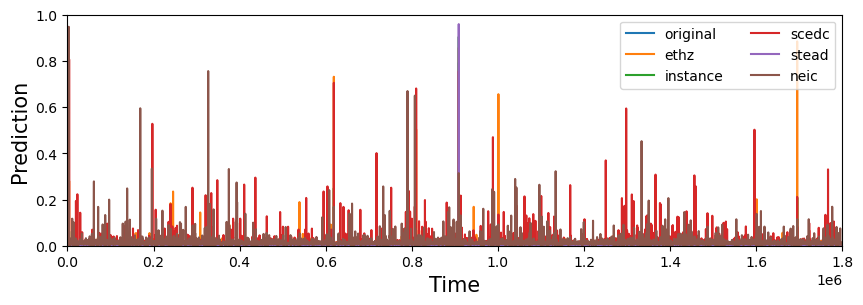

In [14]:
plt.figure(figsize = (10, 3))
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')
plt.xlabel("Time", fontsize = 15)

## 4 ensemble calculation
We then apply the ensemble measurement on each of the time window, and then merge them.

In [15]:
paras_maximum = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.1, 0.05

max_pred = np.zeros([2, nseg, twin], dtype = np.float32)
smb_pred = np.zeros([2, nseg, twin], dtype = np.float32)

In [16]:
# calculate the ensemble maximum and semblance
## the semblance may takes a while bit to calculate
for iseg in tqdm(range(nseg)):
    # 0 for P-wave
    max_pred[0, iseg, :] = ensemble_statistics(batch_pred[0, :, iseg, :], paras_maximum)
    smb_pred[0, iseg, :] = ensemble_semblance(batch_pred[0, :, iseg, :], paras_semblance)
    
    # 1 for P-wave
    max_pred[1, iseg, :] = ensemble_statistics(batch_pred[1, :, iseg, :], paras_maximum)
    smb_pred[1, iseg, :] = ensemble_semblance(batch_pred[1, :, iseg, :], paras_semblance)

## ... and stack
# 0 for P-wave
max_p = stacking(max_pred[0, :], npts, l_blnd, r_blnd)
smb_p = stacking(smb_pred[0, :], npts, l_blnd, r_blnd)

# 1 for P-wave
max_s = stacking(max_pred[1, :], npts, l_blnd, r_blnd)
smb_s = stacking(smb_pred[1, :], npts, l_blnd, r_blnd)

# clean-up RAM
del max_pred, smb_pred, batch_pred

100%|██████████| 599/599 [00:53<00:00, 11.28it/s]
/tmp/ipykernel_3933707/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


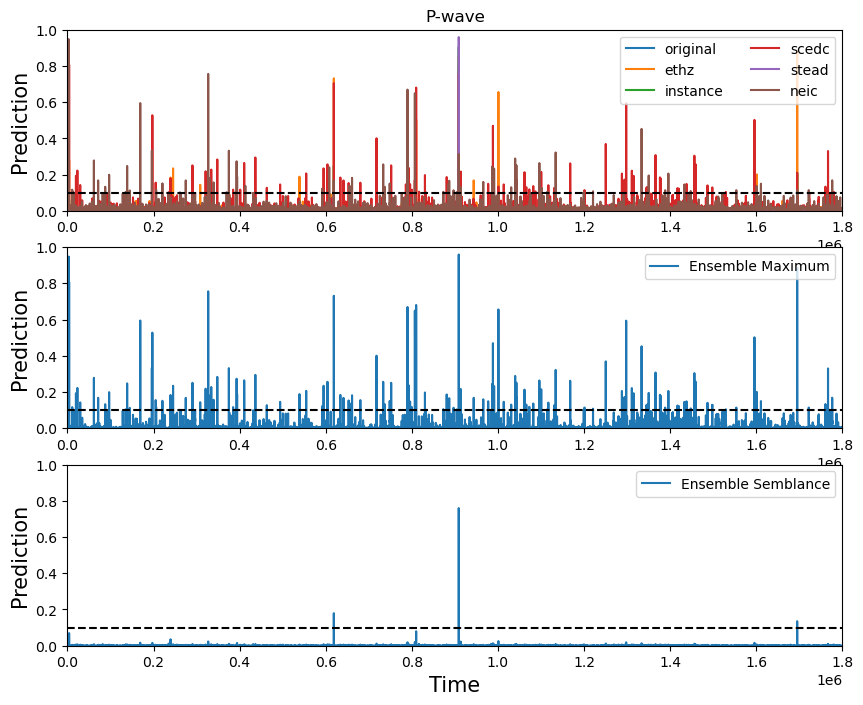

In [17]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("P-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(p_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_p, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(p_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_p, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(p_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

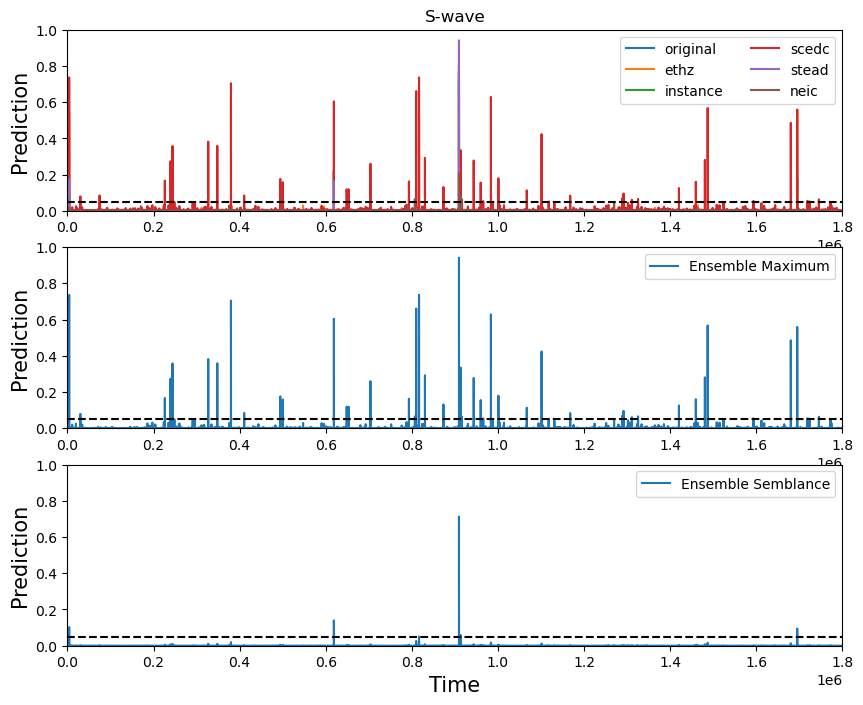

In [18]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("S-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[1, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')
plt.hlines(s_thrd, 0, npts, linestyle = '--', color = 'k')

plt.subplot(3, 1, 2)
plt.plot(max_s, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(s_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')


plt.subplot(3, 1, 3)
plt.plot(smb_s, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(s_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

## 5 picking v.s. catalog

In [19]:
p_index = picks_summary_simple(smb_p, p_thrd)
s_index = picks_summary_simple(smb_s, s_thrd)
print(f"{len(p_index)} P picks\n{len(s_index)} S picks")

3 P picks
6 S picks


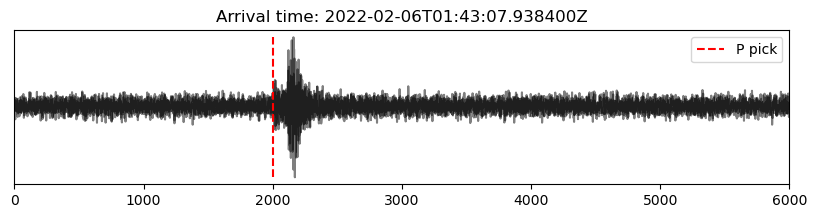

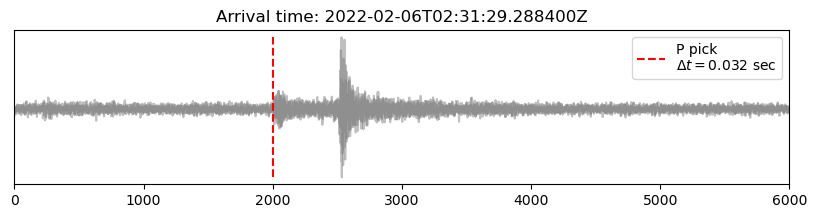

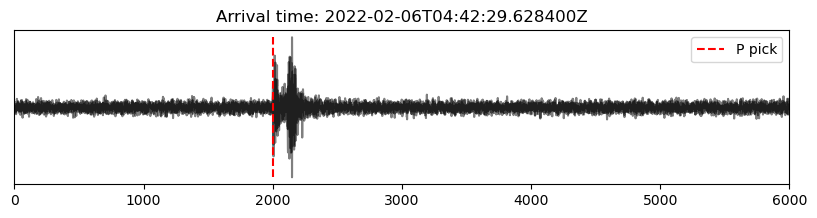

In [20]:
## all picks for this station and this day by PNSN
catalog = pd.read_csv("./data/PB.B204.2022.037.csv")
catalog = catalog[catalog['phase'] == 'P']

## gray waveform: there is a pick by PNSN within 1 second
## black waveform: probably a new event detected
for idx in p_index:
    arrival_utc = starttime + idx * delta
    plt.figure(figsize = (10, 2))
    w = sdata[:, idx-2000:idx+4000]
    nearby_pick = abs(arrival_utc.timestamp - catalog['timestamp']) < 1
    if nearby_pick.any():
        dt = np.abs(catalog.loc[nearby_pick]['timestamp'] - arrival_utc.timestamp)
        plt.plot(w.T, color = 'gray', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', 
                   label=f'P pick \n$\\Delta t = $%.3f sec' % dt.values[0])
    else:
        plt.plot(w.T, color = 'black', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', label = 'P pick')
    plt.title(f"Arrival time: {arrival_utc}")
    plt.yticks([]); plt.legend(loc = 'upper right')
    plt.xlim([0, 6000])

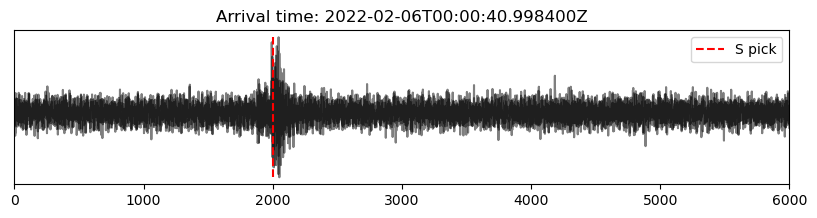

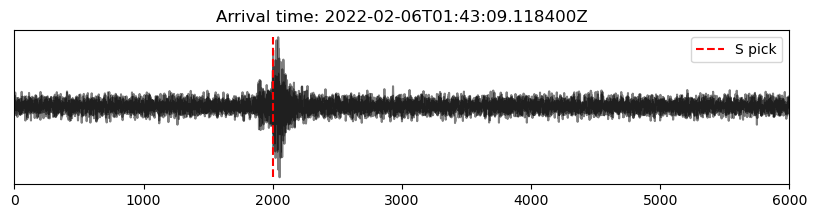

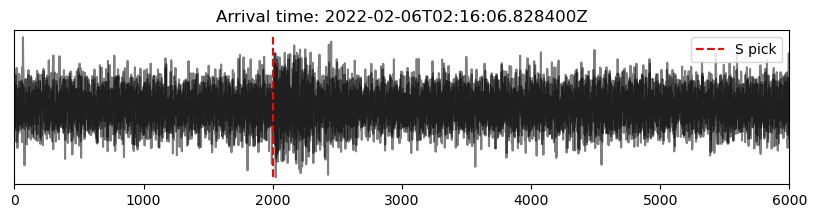

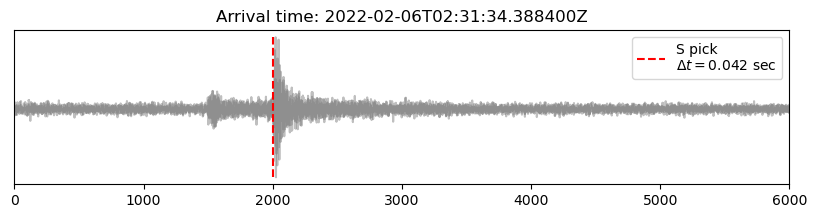

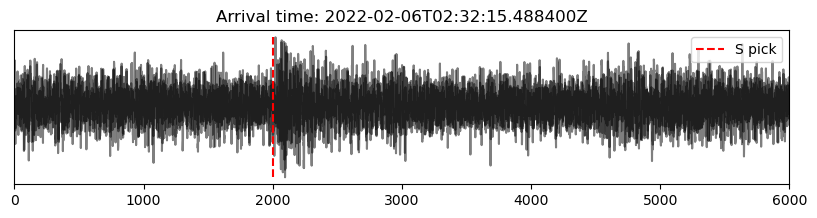

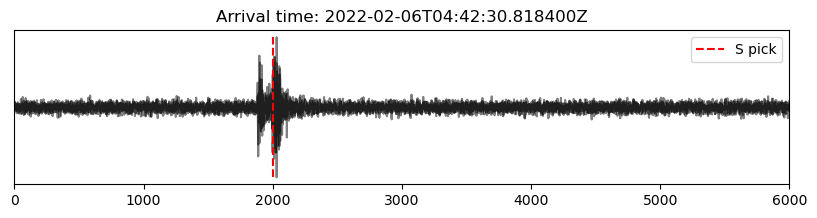

In [21]:
## all picks for this station and this day by PNSN
catalog = pd.read_csv("./data/PB.B204.2022.037.csv")
catalog = catalog[catalog['phase'] == 'S']

## gray waveform: there is a pick by PNSN within 1 second
## black waveform: probably a new event detected
for idx in s_index:
    arrival_utc = starttime + idx * delta
    plt.figure(figsize = (10, 2))
    w = sdata[:, idx-2000:idx+4000]
    nearby_pick = abs(arrival_utc.timestamp - catalog['timestamp']) < 1
    if nearby_pick.any():
        dt = np.abs(catalog.loc[nearby_pick]['timestamp'] - arrival_utc.timestamp)
        plt.plot(w.T, color = 'gray', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', 
                   label=f'S pick \n$\\Delta t = $%.3f sec' % dt.values[0])
    else:
        plt.plot(w.T, color = 'black', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', label = 'S pick')
    plt.title(f"Arrival time: {arrival_utc}")
    plt.yticks([]); plt.legend(loc = 'upper right')
    plt.xlim([0, 6000])

## 6 meta picker

In [22]:
# load pre-trained meta picker
meta_p_picker = torch.load("../../ELEP/models/broadband_P.pt").to("cpu"); meta_p_picker.eval();
meta_s_picker = torch.load("../../ELEP/models/broadband_S.pt").to("cpu"); meta_s_picker.eval();

# show the model structure
meta_p_picker

ensemble_regressor_cnn(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_

In [23]:
# use semblance as the trigger
idt_p = []; idt_s = [];
meta_window_p = np.zeros([len(p_index), 1, 6, 2000], dtype = np.float32)
meta_window_s = np.zeros([len(s_index), 1, 6, 2000], dtype = np.float32)

for iwin, itp in enumerate(p_index):
    if itp <= 1500:
        it1 = 0
    if itp >= 8637499:
        it1 = 863799
    else:
        it1 = itp - np.random.randint(600, 900)
    idt_p.append(it1)
    meta_window_p[iwin, 0, :, :] = pretrain_pred[0, :, it1:it1+2000]

for iwin, its in enumerate(s_index):
    if its <= 1500:
        it1 = 0
    if its >= 8637499:
        it1 = 8637999
    else:
        it1 = its - np.random.randint(600, 900)
    idt_s.append(it1)
    meta_window_s[iwin, 0, :, :] = pretrain_pred[1, :, it1:it1+2000]

In [24]:
# picking
meta_peak_p = meta_p_picker(torch.Tensor(meta_window_p)).detach().numpy()[:, 0]*2000 + idt_p
meta_peak_s = meta_s_picker(torch.Tensor(meta_window_s)).detach().numpy()[:, 0]*2000 + idt_s

Text(0, 0.5, 'Raw Waveform')

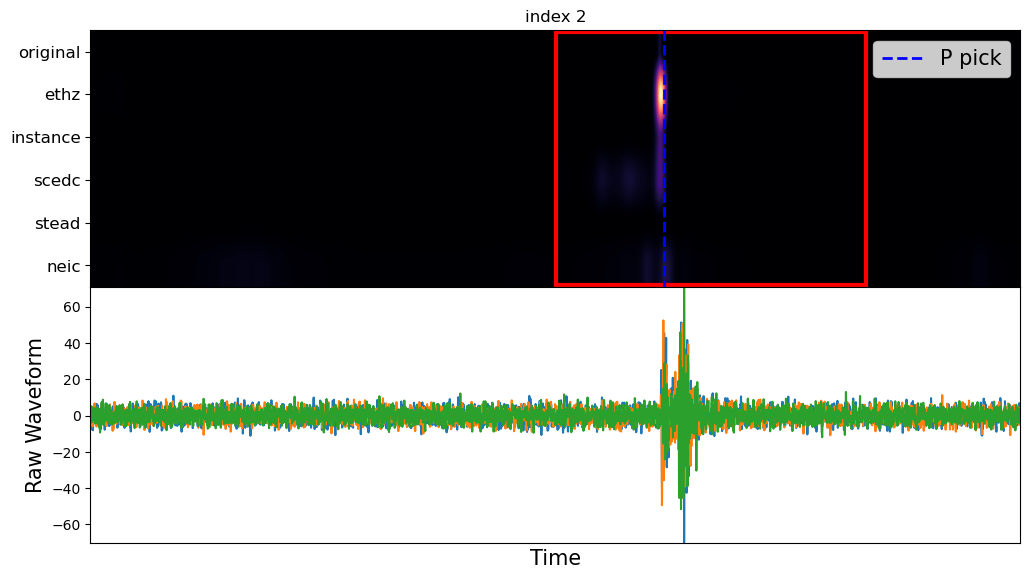

In [33]:
## all picks for this station and this day by PNSN
catalog = pd.read_csv("./data/PB.B204.2022.037.csv")
catalog = catalog[catalog['phase'] == 'P']
catalog = catalog[catalog['hour']<=5]

# for plotting only
iwin = np.random.randint(len(meta_peak_p))
idt = idt_p[iwin]

plt.figure(figsize = (12, 10))
plt.subplots_adjust(hspace = 0.)
plt.subplot(3, 1, 1)
plt.title(f"index {iwin}")
plt.imshow(pretrain_pred[0, :, idt-3000:idt+3000], aspect = 'auto', cmap = 'magma')
_ = plt.yticks(np.arange(6), pretrain_list, fontsize = 12)
plt.gca().add_patch(Rectangle((3000, -0.45), 2000, 5.92, 
                              facecolor = 'None', edgecolor = 'red', linewidth = 3))

plt.vlines(meta_peak_p[iwin] - idt + 3000, -.5, 5.5,
           color = 'b', label = "P pick", linewidth = 2, linestyle = '--')
plt.legend(loc = 'upper right', fontsize = 15); 
plt.xticks([])

plt.subplot(3, 1, 2)
d = sdata[:, idt-3000:idt+3000]
plt.plot(d.T)
plt.xlim([0, 6000]); plt.ylim([d.min(), d.max()])
plt.xticks([]); plt.xlabel("Time", fontsize = 15)
plt.ylabel("Raw Waveform", fontsize = 15)

Text(0, 0.5, 'Raw Waveform')

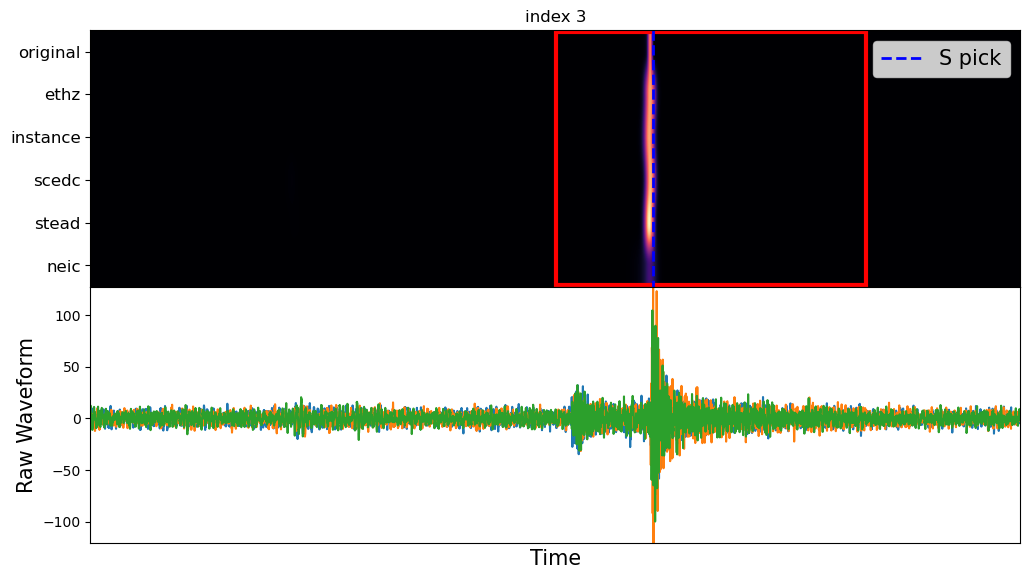

In [35]:
## all picks for this station and this day by PNSN
catalog = pd.read_csv("./data/PB.B204.2022.037.csv")
catalog = catalog[catalog['phase'] == 'S']
catalog = catalog[catalog['hour']<=5]

# for plotting only
iwin = np.random.randint(len(meta_peak_s))
idt = idt_s[iwin]

plt.figure(figsize = (12, 10))
plt.subplots_adjust(hspace = 0.)
plt.subplot(3, 1, 1)
plt.title(f"index {iwin}")
plt.imshow(pretrain_pred[1, :, idt-3000:idt+3000], aspect = 'auto', cmap = 'magma')
_ = plt.yticks(np.arange(6), pretrain_list, fontsize = 12)
plt.gca().add_patch(Rectangle((3000, -0.45), 2000, 5.92, 
                              facecolor = 'None', edgecolor = 'red', linewidth = 3))

plt.vlines(meta_peak_s[iwin] - idt + 3000, -.5, 5.5,
           color = 'b', label = "S pick", linewidth = 2, linestyle = '--')
plt.legend(loc = 'upper right', fontsize = 15); 
plt.xticks([])

plt.subplot(3, 1, 2)
d = sdata[:, idt-3000:idt+3000]
plt.plot(d.T)
plt.xlim([0, 6000]); plt.ylim([d.min(), d.max()])
plt.xticks([]); plt.xlabel("Time", fontsize = 15)
plt.ylabel("Raw Waveform", fontsize = 15)

## 5 save picks to pd.DataFrame (... and save as csv)

In [36]:
all_picks = [[UTCDateTime(i), "P"] for i in meta_peak_p/100 + starttime.timestamp] + \
            [[UTCDateTime(i), "S"] for i in meta_peak_s/100 + starttime.timestamp]
df = pd.DataFrame(all_picks, columns=['time', 'phase'])
df

,time,phase
0,2022-02-06T01:43:08.034257Z,P
1,2022-02-06T02:31:29.352044Z,P
2,2022-02-06T04:42:29.821039Z,P
3,2022-02-06T00:00:41.173471Z,S
4,2022-02-06T01:43:09.583384Z,S
5,2022-02-06T02:16:07.363148Z,S
6,2022-02-06T02:31:34.605537Z,S
7,2022-02-06T02:32:16.288792Z,S
8,2022-02-06T04:42:31.046154Z,S


In [37]:
df.to_csv("./data/picks_metalearner_PB.B204.2022.037.csv", index = False)

# EOF